In [1]:
import pandas as pd
import numpy as np
import nibabel as nib
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from athletes_brain.fig2.config import GROUP_NAMES

2025-07-03 16:21:31.635 | INFO     | athletes_brain.config:<module>:11 - PROJ_ROOT path is: /home/galkepler/Projects/athletes_brain


In [2]:
# ── Global visualisation configuration ──────────────────────────────────────

# 1.  General Matplotlib defaults
# ── Global visualisation configuration ──────────────────────────────────────
import matplotlib as mpl
import seaborn as sns

mpl.rcParams.update(
    {
        # ── Canvas size & resolution ───────────────────────────────────────────
        # Default figure size: 12×8 inches  →  4800×3200 px when exported at 400 dpi
        "figure.figsize": (12, 8),
        "figure.dpi": 200,  # crisp in-notebook / retina preview
        "savefig.dpi": 400,  # print-quality PNG/PDF
        # ── Fonts ──────────────────────────────────────────────────────────────
        "font.family": "sans-serif",
        "font.sans-serif": ["Roboto", "DejaVu Sans", "Arial"],
        "axes.titlesize": 24,
        # "axes.titleweight": "bold",
        "axes.labelsize": 24,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "legend.fontsize": 20,
        # ── Axis & spine aesthetics ────────────────────────────────────────────
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.linewidth": 1,
        "axes.grid": True,
        "grid.color": "#E6E6E6",
        "grid.linewidth": 0.4,
        "grid.alpha": 0.8,
        # ── Colour cycle (colour-blind-safe) ───────────────────────────────────
        "axes.prop_cycle": mpl.cycler(color=sns.color_palette("Set2")),
        # ── Figure background ─────────────────────────────────────────────────
        "figure.facecolor": "white",
    }
)

# Seaborn theme inherits the rcParams above
sns.set_theme(context="talk", style="whitegrid", palette="Set2")


# 2.  Seaborn theme (inherits Matplotlib rcParams)
sns.set_theme(
    context="talk",  # slightly larger fonts for presentations / papers
    style="whitegrid",  # grid only on y-axis (good for histograms)
    palette="Set2",  # matches the rcParams colour cycle
)


# 3.  Helper function for consistent figure export
def savefig_nice(fig, filename, *, tight=True, dpi=300, **savefig_kwargs):
    """Save figure with tight layout and correct DPI."""
    if tight:
        fig.tight_layout()
    fig.savefig(filename, dpi=dpi, bbox_inches="tight", transparent=True, **savefig_kwargs)


# 4.  Colour constants for this project (optional convenience)
COL_RAW = "#1f77b4"  # e.g. unweighted sample
COL_WEIGHTED = "#d62728"  # weighted sample
COL_REF = "0.35"  # census reference (neutral grey)

In [3]:
ATLAS = "schaefer2018tian2020_400_7"
region_col = "index"
# Load important files
DATA_DIR = Path("/home/galkepler/Projects/athletes_brain/data")

# Output directory for figures
OUTPUT_DIR = Path("/home/galkepler/Projects/athletes_brain/figures/fig2")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the data
parcels = pd.read_csv(DATA_DIR / "external" / "atlases" / ATLAS / "parcels.csv", index_col=0)
nifti = DATA_DIR / "external" / "atlases" / ATLAS / "atlas.nii.gz"
nifti_matlab = DATA_DIR / "external" / "atlases" / ATLAS / "atlas_matlab.nii"

In [4]:
# metrics = ["gm_vol", "wm_vol", "csf_vol", "adc", "fa", "ad", "rd"]
metrics = ["gm_vol", "adc"]
distribution_metric = "qfmean"

bad_subjects = ["IN120120"]

In [5]:
# Load the data
data = {}
for metric in metrics:
    data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
        drop=True
    )
    # data[metric] = data[metric].drop_duplicates(subset=["subject_code", region_col], keep="last")
    # drop problematic subjects
    data[metric] = data[metric][~data[metric]["subject_code"].isin(bad_subjects)]
    data[metric]["sex"] = data[metric]["sex"].map({"M": 0, "F": 1})
    data[metric] = data[metric].drop_duplicates(subset=["subject_code", region_col], keep="last")


# data["age_squared"] = data["age_at_scan"] ** 2

/tmp/ipykernel_2762105/1005474517.py:4: DtypeWarning: Columns (1,8,9,10,11,12,68) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(
/tmp/ipykernel_2762105/1005474517.py:4: DtypeWarning: Columns (16,23,24,25,26,27,33) have mixed types. Specify dtype option on import or set low_memory=False.
  data[metric] = pd.read_csv(DATA_DIR / "processed" / f"{metric}.csv", index_col=0).reset_index(


In [6]:
metric_cols = {metric: "volume" if "vol" in metric else distribution_metric for metric in metrics}

for m, df in data.items():
    df = df.rename(columns={metric_cols[m]: "value"})
    data[m] = df

In [7]:
import pandas as pd
import numpy as np
from functools import reduce

# Assuming 'region_col' is defined globally (e.g., 'Region_Name' or 'Region_ID')
# Make sure to define it if not already:
# region_col = 'Region_ID' # Example, adapt to your actual region column name


# --- Adapted `long_to_wide` Function ---
def long_to_wide(
    long_df,
    *,
    index_cols=["subject_code", "session_id"],  # Use both for unique sessions
    columns_to_pivot=region_col,  # Your region column name
    values_col="value",
    demographic_cols=[
        "age_at_scan",
        "sex",
        "group",
        "target",
        "tiv",
    ],  # Include all relevant demographics/targets
):
    """
    Pivots a long metric table to a wide DataFrame (sessions x features),
    while preserving demographic and target columns.

    Parameters
    ----------
    long_df : pd.DataFrame
        Input DataFrame in long format with columns like index_cols, columns_to_pivot,
        values_col, and demographic_cols.
    index_cols : list of str
        Columns to use as the index for pivoting (e.g., ['Participant_ID', 'Session_ID']).
    columns_to_pivot : str
        Column containing the region names/IDs to become new columns.
    values_col : str
        Column containing the metric values.
    demographic_cols : list of str
        Other columns to preserve (demographics, target variables).

    Returns
    -------
    pd.DataFrame
        Wide-format DataFrame with (Participant_ID, Session_ID) as a multi-index,
        region values as columns (prefixed with metric type), and
        demographic/target columns.
    """
    # Ensure all index_cols and demographic_cols are in the DataFrame
    if not all(col in long_df.columns for col in index_cols + [columns_to_pivot, values_col]):
        raise ValueError(
            f"Missing essential columns for pivoting. Required: {index_cols + [columns_to_pivot, values_col]}"
        )

    # Filter demographic_cols to only those actually present in the long_df
    present_demographic_cols = [col for col in demographic_cols if col in long_df.columns]

    # Handle multiple sessions per participant if Session_ID is not explicit
    if "session_id" not in long_df.columns:
        long_df["session_id"] = long_df.groupby("Participant_ID").cumcount() + 1
        print(
            "  Warning: 'Session_ID' not found in long_df. Generated dummy Session_ID for pivoting."
        )

    # Select columns to pivot and drop duplicates for the index/demographics
    # We drop duplicates to ensure only one set of demographic/target data per session
    meta_df = long_df[index_cols + present_demographic_cols].drop_duplicates(subset=index_cols)
    meta_df = meta_df.set_index(index_cols)

    # Pivot the metric data
    wide_metric = long_df.pivot_table(
        index=index_cols, columns=columns_to_pivot, values=values_col
    )

    # Merge demographics back. Ensure column names from wide_metric are unique.
    # The columns from wide_metric are already the region names, no prefix needed here yet.
    full_wide_df = meta_df.join(
        wide_metric, how="inner"
    )  # Inner join to ensure only sessions with metric data

    # Optional: Missing value thresholding
    # These thresholds might need careful consideration in a multimodal context
    # as dropping columns from one metric might affect others later.
    # For initial combined ML, it's often better to drop NaNs at the end on the full feature set.
    # You can re-enable if you want to filter per-metric-wise first.
    # thresh_cols = int(0.8 * len(full_wide_df))
    # full_wide_df = full_wide_df.dropna(axis=1, thresh=thresh_cols)
    # thresh_rows = int(0.8 * len(wide_metric.columns)) # Assuming parcels is wide_metric.columns
    # full_wide_df = full_wide_df.dropna(axis=0, thresh=thresh_rows)

    return full_wide_df.reset_index()

In [8]:
common_sessions = []
data_wide = {}
for metric, df in data.items():
    data_wide[metric] = long_to_wide(df)
    common_sessions.append(set(data_wide[metric]["session_id"].unique()))
# Find common sessions across all metrics
common_sessions = reduce(lambda x, y: x.intersection(y), common_sessions)
# Filter each metric DataFrame to only include common sessions
for metric in data_wide:
    data_wide[metric] = data_wide[metric][data_wide[metric]["session_id"].isin(common_sessions)]

In [9]:
import statsmodels.formula.api as smf

scns = {}
covariates = ["sex"] if metric != "gm_vol" else ["sex", "tiv"]

wide_df = data_wide["adc"].copy()

In [10]:
# subject_col = "subject_code"  # Define the subject column name
# for i,row in parcels.iterrows():
#     roi = row[region_col]
#     df_tmp = pd.DataFrame()
#     df_tmp[subject_col] = wide_df[subject_col].astype("category").cat.codes
#     df_tmp[covariates] = wide_df[covariates].values
#     df_tmp["value"] = wide_df[roi].values
#     model = smf.ols("value ~ " + " + ".join(covariates), data=df_tmp).fit()
#     wide_df[roi] = model.resid + model.params["Intercept"]
#     # break

In [12]:
def estimate_scn(
    wide_df: dict,
    metric: str,
    parcels: pd.DataFrame,
    region_col: str = "index",
    subject_col: str = "subject_code",
    group_by: str = "column",
):
    """
    Estimate Structural Covariance Networks (SCNs) from the provided data.
    Parameters:
    - data: DataFrame containing the data with columns 'subject_code', 'value', and 'region_col'
    - metric: Metric to be used for SCN estimation (e.g., 'gm_vol', 'thickness')
    - region_col: Column name for the brain region
    - age_col: Column name for age
    - n_bins: Number of age bins to create for grouping participants by age
    Returns:
    - scns: Dictionary containing SCNs for each age group with correlation matrices and metadata
    """
    scns = {}
    # long_df = data.copy().drop_duplicates(subset=[subject_col, region_col], keep="last")
    covariates = ["sex"] if metric != "gm_vol" else ["sex", "tiv"]

    # correct for sex
    # wide_df = long_df.pivot_table(index="subject_code", columns=[region_col], values="value")
    # residualise for sex, and if needed, for TIV
    for i, row in parcels.iterrows():
        col = row[region_col]
        df_tmp = pd.DataFrame(index=wide_df.index)
        df_tmp[subject_col] = wide_df.index
        df_tmp[covariates] = wide_df[covariates].copy()
        df_tmp["value"] = wide_df[col]
        # do mixed effects regression
        model = smf.ols("value ~ " + " + ".join(covariates), data=df_tmp).fit()
        wide_df[col] = model.resid + model.params["Intercept"]
        # break
    # break

    # Step 2: Add age group info to wide matrix
    for group_name, group_df in wide_df.groupby(group_by):
        # Create a new column for each age group
        region_matrix = wide_df.loc[group_df["subject_code"]]
        corr_matrix = region_matrix.corr(method="spearman")
        scns[group_name] = {"corr_matrix": corr_matrix, "metadata": group_df}
    # Step 3: Return the dictionary of SCNs
    return scns

In [41]:
# from athletes_brain.fig4.calculate_network_measures import estimate_scn
N_ITER = 100
# estimate_scn(wide_df=wide_df, metric="adc",group_by="target", parcels=parcels, region_col=region_col)
for group_name, group_df in wide_df.groupby("target"):
    corr_matrix = np.zeros((len(parcels), len(parcels)))
    if group_name == False:
        # iteratively sample the group_df to match the number of athletes
        for i in range(N_ITER):
            sampled_df = group_df.sample(n=len(wide_df[wide_df["target"] == True]), replace=True)
            region_matrix = sampled_df[parcels[region_col].values]
            corr_matrix += region_matrix.corr(method="spearman").values
        corr_matrix /= N_ITER
    else:
        region_matrix = group_df[parcels[region_col].values]
        corr_matrix = region_matrix.corr(method="spearman")
    scns[group_name] = {"corr_matrix": corr_matrix, "metadata": group_df}
    # break

In [42]:
from mne.viz import circular_layout

parcels_vis = parcels.copy()

colors = sns.color_palette("Set2", n_colors=parcels_vis["network"].nunique())
networks = parcels_vis["network"].unique()
# keep "subcortex" network at the end
colors_mapping = dict(zip(parcels_vis["network"].unique(), colors))
parcels_vis["color"] = parcels_vis["network"].map(colors_mapping)

# sort parcels by hemi and network (make one hemi a mirror image of the other)
hemi_l = parcels_vis[parcels_vis["hemisphere"] == "L"]
hemi_r = parcels_vis[parcels_vis["hemisphere"] == "R"].iloc[::-1]
parcels_vis = pd.concat([hemi_l, hemi_r], ignore_index=True)

# automatically set unique colors for each network
# "network" is a columns with strings like "Visual", "Somatomotor", etc.


node_angles = circular_layout(
    parcels_vis[region_col].tolist(),
    node_order=parcels_vis[region_col].tolist(),
    # start_pos=-68,
    # group_boundaries=parcels_vis["network"].astype("category").cat.codes.tolist(),
    # group_colors=parcels_vis["color"].tolist(),
)

node_grouping = parcels_vis["network"].astype("category").cat.codes.tolist()
group_labels = parcels_vis["network"].unique().tolist()

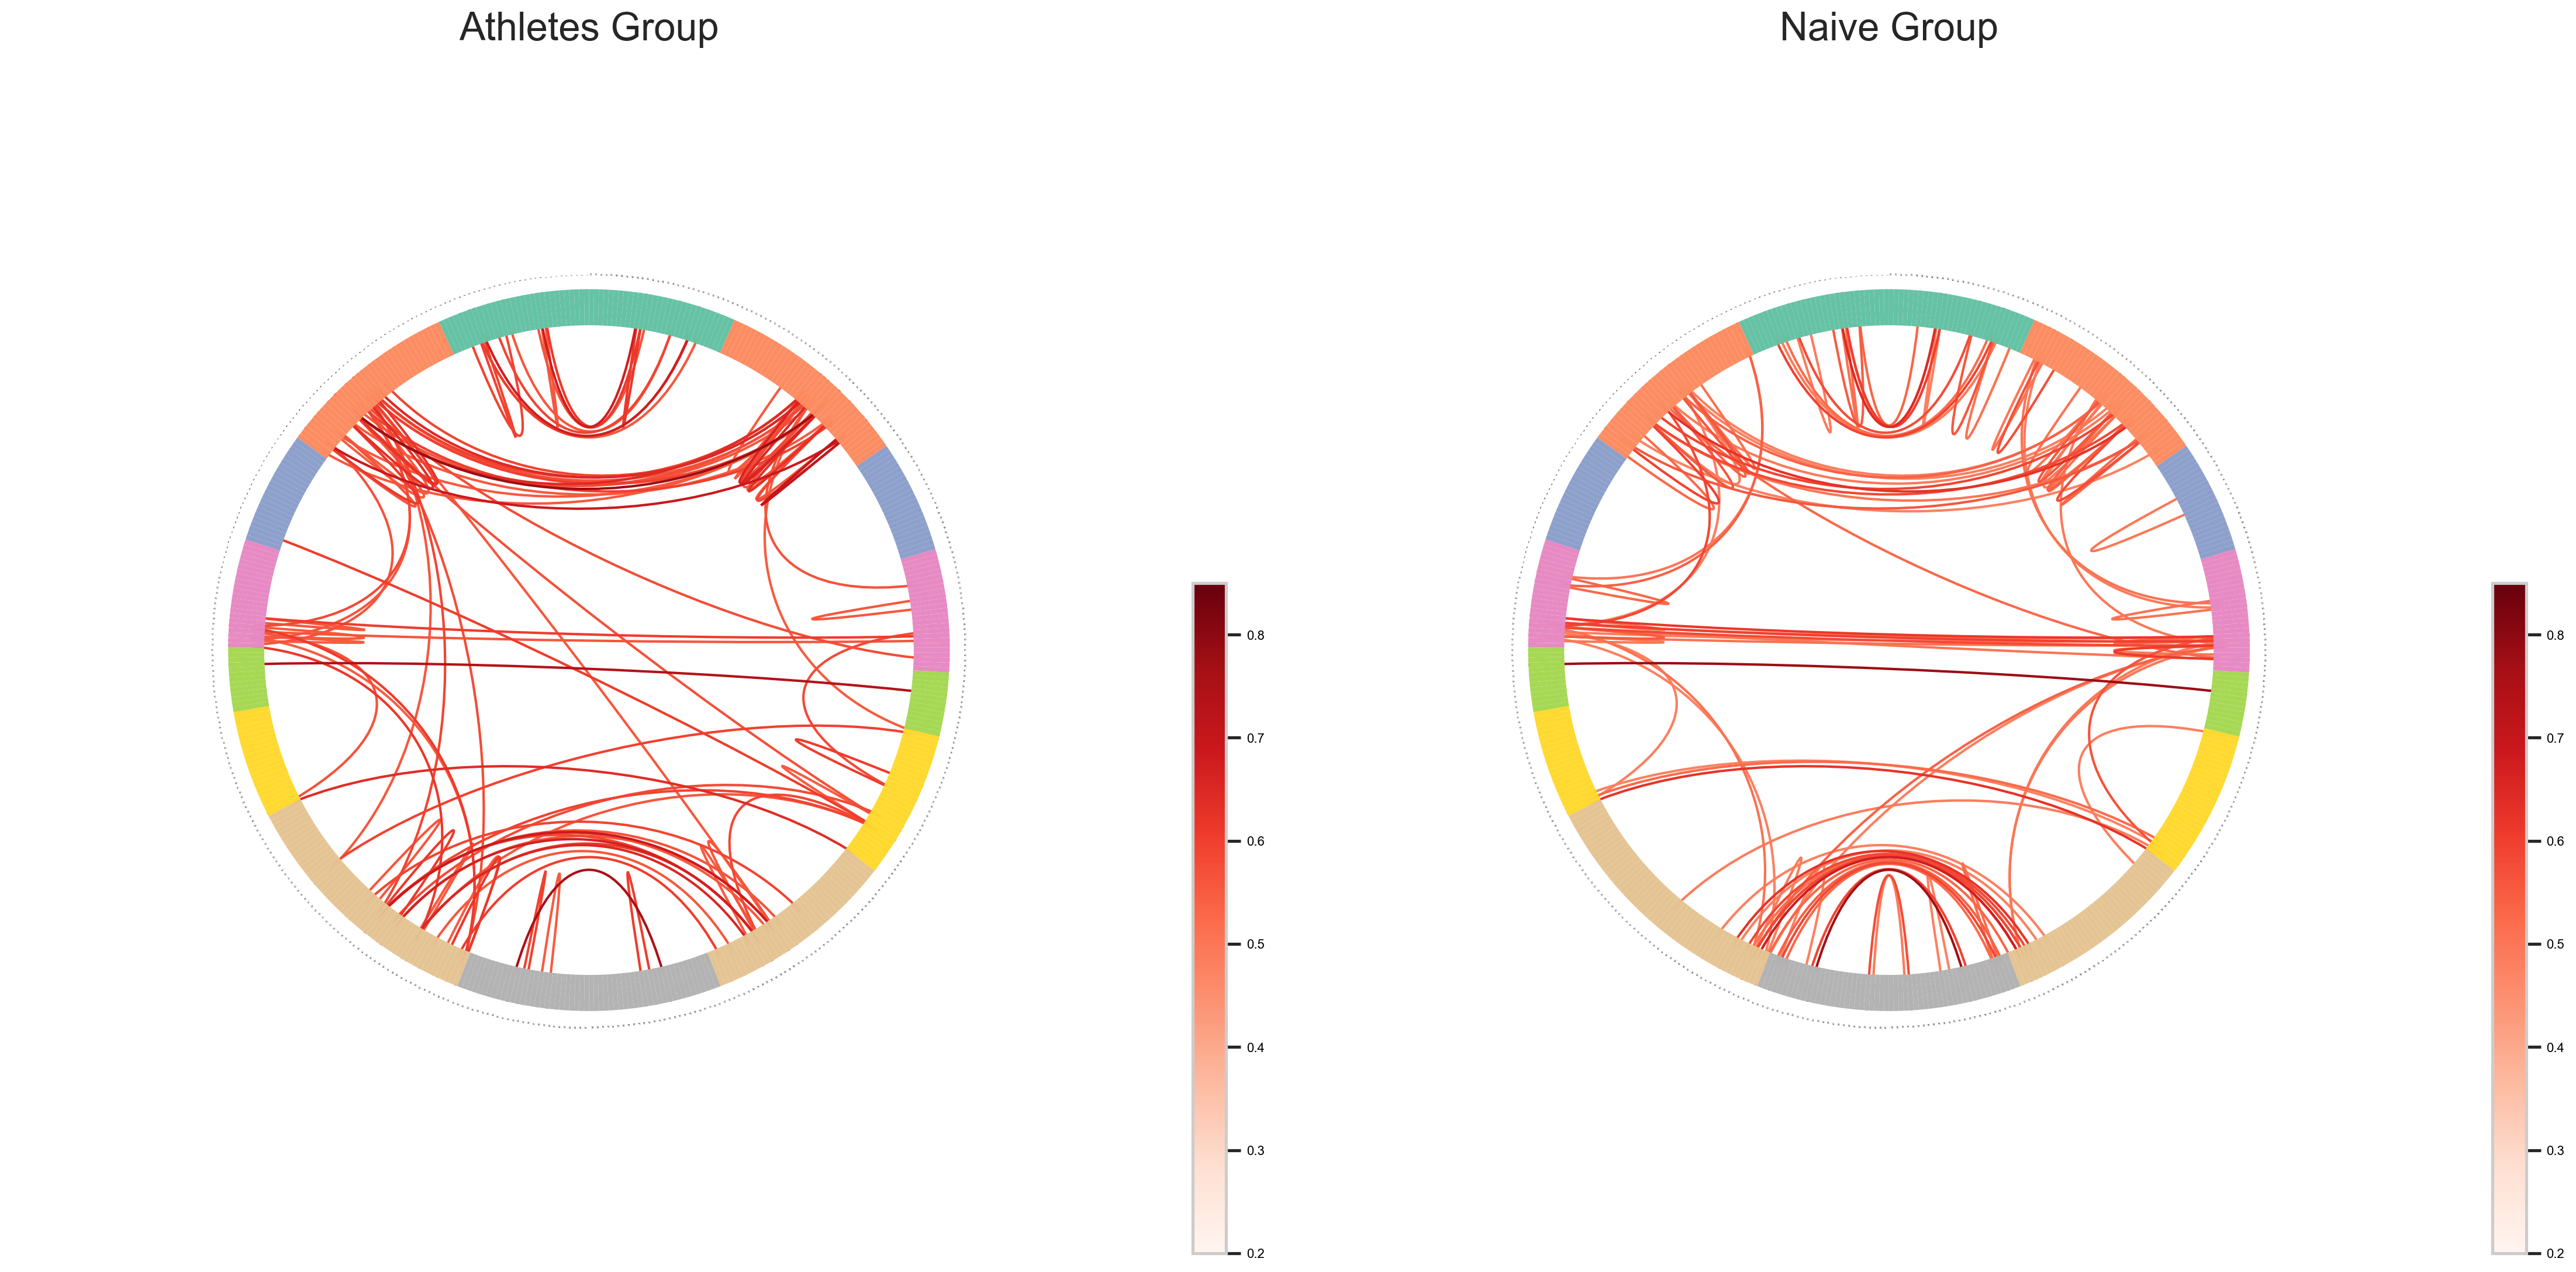

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from mne_connectivity.viz import plot_connectivity_circle

group_title = {False: "Naive Group", True: "Athletes Group"}
q = True

fig, axes = plt.subplots(1, 2, figsize=(24, 12), subplot_kw={"projection": "polar"})
for ax, q in zip(axes, [True, False]):
    mat = scns[q]["corr_matrix"].values

    # threshold = 0.7
    threshold = 0

    # zero diagonal
    np.fill_diagonal(mat, 0)
    # Threshold the connectivity matrix
    masked_matrix = np.where(np.abs(mat) < threshold, np.nan, mat)
    masked_matrix = pd.DataFrame(
        masked_matrix, index=parcels[region_col], columns=parcels[region_col]
    )
    masked_matrix = masked_matrix[parcels_vis[region_col]].loc[parcels_vis[region_col]].values

    # The plotting function from MNE
    plot_connectivity_circle(
        masked_matrix**2,
        node_names=parcels[region_col].astype(str).tolist(),
        node_colors=parcels_vis["color"].tolist(),
        node_angles=node_angles,
        node_edgecolor=None,
        n_lines=100,
        facecolor="white",
        textcolor="black",
        colormap="Reds",
        vmin=0.2,
        vmax=0.85,
        ax=ax,
        show=False,
        # node_grouping=node_grouping,
        # group_boundaries=['black'] * len(group_labels),
        # group_labels=group_labels,
        colorbar_pos=(-0.25, 0.1),  # Adjust colorbar position
        colorbar_size=0.5,
        node_linewidth=0,
        fontsize_names=0,
        # colorbar_label='Correlation Strength'
    )

    # Set the title for the plot
    ax.set_title(group_title[q], fontsize=24, pad=20)
    plt.tight_layout()
    # savefig_nice(
    #     fig,
    #     OUTPUT_DIR / f"connectivity_circle_Q{q}.png",
    #     tight=True,
    #     dpi=300,
    # )